# Multi Logistic Regression Analysis
Video can be found at: https://www.youtube.com/watch?v=zM4VZR0px8E

## Import our Libraries
The first thing we need to do is import the libraries we will be using in this tutorial. To visualize our data, we will be using matplotlib and seaborn to create heatmaps and a scatter matrix. To build our model, we will be using the sklearn library, and the evaluation will be taking place with the statsmodels library. I've also added a few additional modules to help calculate certain metrics.

## Load and Format Data

In [121]:
#import packages
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import linregress

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

In [122]:
#load team data
game_data = pd.read_csv('gamelog_adv.csv')
game_data.head()

,Team,Conference,Division,Game Number in The Season,Season,Date,Home or Away,Opponent,GF,GA,...,CF%,FF,FA,FF%,FOW,FOL,FO%,oZS%,PDO,Blocked Shots
0,WSH,Eastern,Metropolitan,1,2018-19,10/3/2018,Home,Boston Bruins,7,0,...,47.7,31,31,50.0,16,32,33.3,60.7,113.0,14
1,WSH,Eastern,Metropolitan,2,2018-19,10/4/2018,Away,Pittsburgh Penguins,6,7,...,43.4,36,47,43.4,26,30,46.4,60.7,105.7,13
2,WSH,Eastern,Metropolitan,3,2018-19,10/10/2018,Home,Vegas Golden Knights,5,2,...,40.6,34,41,45.3,26,30,46.4,40.5,105.4,19
3,WSH,Eastern,Metropolitan,4,2018-19,10/11/2018,Away,New Jersey Devils,0,6,...,43.4,26,48,35.1,18,31,36.7,45.7,84.8,8
4,WSH,Eastern,Metropolitan,5,2018-19,10/13/2018,Home,Toronto Maple Leafs,2,4,...,50.5,33,32,50.8,19,19,50.0,47.6,90.9,16


In [123]:
#turn game number to string
game_data['Game Number in The Season'] = game_data['Game Number in The Season'].astype(str)

#change game outcome to 0 or 1
game_data['Win or Loss'] = game_data['Win or Loss'].map({'W': 1, 'L': 0})

# concatenate team and game number to get unique identifier for rows
game_data['ID'] = game_data['Team'] +"_"+ game_data['Game Number in The Season']
game_data.head()

,Team,Conference,Division,Game Number in The Season,Season,Date,Home or Away,Opponent,GF,GA,...,FF,FA,FF%,FOW,FOL,FO%,oZS%,PDO,Blocked Shots,ID
0,WSH,Eastern,Metropolitan,1,2018-19,10/3/2018,Home,Boston Bruins,7,0,...,31,31,50.0,16,32,33.3,60.7,113.0,14,WSH_1
1,WSH,Eastern,Metropolitan,2,2018-19,10/4/2018,Away,Pittsburgh Penguins,6,7,...,36,47,43.4,26,30,46.4,60.7,105.7,13,WSH_2
2,WSH,Eastern,Metropolitan,3,2018-19,10/10/2018,Home,Vegas Golden Knights,5,2,...,34,41,45.3,26,30,46.4,40.5,105.4,19,WSH_3
3,WSH,Eastern,Metropolitan,4,2018-19,10/11/2018,Away,New Jersey Devils,0,6,...,26,48,35.1,18,31,36.7,45.7,84.8,8,WSH_4
4,WSH,Eastern,Metropolitan,5,2018-19,10/13/2018,Home,Toronto Maple Leafs,2,4,...,33,32,50.8,19,19,50.0,47.6,90.9,16,WSH_5


In [124]:
#remove variables won't be used or that will have high multicolinearity 
game_data = game_data.drop(['Team','Conference ', 'Division', 'Game Number in The Season', 'Season', 'Date',
                            'Home or Away','Opponent','GF','GA','PPO','PPG','PPG Against','SHG','SHG Against',
                           'FOW','FOL','CF','CA','FF','FA','Overtime Status (OT or SO)','Final Result'], axis = 1)

game_data.head()

,Win or Loss,S,PIM,PP%,Shots Against,Penalty Minutes by Opponent,PPO Against,PK%,CF%,FF%,FO%,oZS%,PDO,Blocked Shots,ID
0,1,37,14,67%,25,32,2,100.00%,47.7,50.0,33.3,60.7,113.0,14,WSH_1
1,0,36,12,0%,41,4,6,66.67%,43.4,43.4,46.4,60.7,105.7,13,WSH_2
2,1,29,6,50%,31,8,3,100.00%,40.6,45.3,46.4,40.5,105.4,19,WSH_3
3,0,21,10,0%,36,10,4,75.00%,43.4,35.1,36.7,45.7,84.8,8,WSH_4
4,0,27,6,33%,28,6,3,66.67%,50.5,50.8,50.0,47.6,90.9,16,WSH_5


In [125]:
#Turn %'s to actual numbers
game_data['PP%'] = game_data['PP%'].str.replace('%','')
game_data['PP%'] = game_data['PP%'].astype(float)

game_data['PK%'] = game_data['PK%'].str.replace('%','')
game_data['PK%'] = game_data['PK%'].astype(float)

In [126]:
# make sure columns are floats
cols = game_data.columns.drop(['ID'])
game_data[cols] = game_data[cols].astype(float)

# set the index to the ID
game_data = game_data.set_index('ID')
game_data.head()

game_data.head()

,Win or Loss,S,PIM,PP%,Shots Against,Penalty Minutes by Opponent,PPO Against,PK%,CF%,FF%,FO%,oZS%,PDO,Blocked Shots
ID,,,,,,,,,,,,,,
WSH_1,1.0,37.0,14.0,67.0,25.0,32.0,2.0,100.00,47.7,50.0,33.3,60.7,113.0,14.0
WSH_2,0.0,36.0,12.0,0.0,41.0,4.0,6.0,66.67,43.4,43.4,46.4,60.7,105.7,13.0
WSH_3,1.0,29.0,6.0,50.0,31.0,8.0,3.0,100.00,40.6,45.3,46.4,40.5,105.4,19.0
WSH_4,0.0,21.0,10.0,0.0,36.0,10.0,4.0,75.00,43.4,35.1,36.7,45.7,84.8,8.0
WSH_5,0.0,27.0,6.0,33.0,28.0,6.0,3.0,66.67,50.5,50.8,50.0,47.6,90.9,16.0


In [127]:
desc_df = game_data.describe()

# add the standard deviation metric
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

desc_df

,Win or Loss,S,PIM,PP%,Shots Against,Penalty Minutes by Opponent,PPO Against,PK%,CF%,FF%,FO%,oZS%,PDO,Blocked Shots
count,7544.000000,7544.000000,7544.000000,7386.000000,7544.000000,7544.000000,7544.000000,7386.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000,7544.000000
mean,0.500000,31.216198,8.572773,19.723125,31.216198,8.572773,2.982105,80.254815,50.000676,50.000835,50.000451,50.001246,100.000530,12.246554
std,0.500033,6.706755,6.379405,26.219310,6.706755,6.374790,1.467243,26.223449,7.789080,8.073554,7.785277,11.403105,9.322139,4.494217
min,0.000000,12.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,23.200000,21.600000,15.000000,12.000000,61.500000,0.000000
25%,0.000000,26.000000,4.000000,0.000000,26.000000,4.000000,2.000000,66.670000,44.700000,44.300000,44.700000,42.100000,93.500000,9.000000
50%,0.500000,31.000000,8.000000,0.000000,31.000000,8.000000,3.000000,100.000000,50.000000,50.000000,50.000000,50.000000,100.000000,12.000000
75%,1.000000,36.000000,10.000000,33.000000,36.000000,10.000000,4.000000,100.000000,55.300000,55.700000,55.300000,57.900000,106.500000,15.000000
max,1.000000,60.000000,96.000000,100.000000,60.000000,96.000000,10.000000,100.000000,76.800000,78.400000,85.000000,88.000000,138.500000,32.000000
+3_std,2.000099,51.336463,27.710989,98.381056,51.336463,27.697143,7.383834,158.925163,73.367917,74.221497,73.356281,84.210562,127.966946,25.729204
-3_std,-1.000099,11.095933,-10.565443,-58.934806,11.095933,-10.551597,-1.419624,1.584466,26.633435,25.780173,26.644620,15.791930,72.034114,-1.236097


In [128]:
#drop na's
game_data.dropna()
np.nan_to_num(game_data)

array([[  1. ,  37. ,  14. , ...,  60.7, 113. ,  14. ],
       [  0. ,  36. ,  12. , ...,  60.7, 105.7,  13. ],
       [  1. ,  29. ,   6. , ...,  40.5, 105.4,  19. ],
       ...,
       [  1. ,  20. ,  34. , ...,  42.6, 112.6,  13. ],
       [  1. ,  26. ,  16. , ...,  33.5, 117.6,   8. ],
       [  1. ,  24. ,  10. , ...,  34.4, 101.7,  13. ]])

In [129]:
# filter the data frame to remove the values exceeding 3 standard deviations (outliers)
game_remove_data = game_data[(np.abs(stats.zscore(game_data)) < 3).all(axis=1)]

#how many rows were removed
len(game_data_filtered)-len(game_remove_data)

C:\Users\jvanzalk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


7544

## Check for Multicolinearity
Multicollinearity is where one of the explanatory variables is highly correlated with another explanatory variable. This can make the coefficient (slope) estimates unreliable. 

,Win or Loss,S,PIM,PP%,Shots Against,Penalty Minutes by Opponent,PPO Against,PK%,CF%,FF%,FO%,oZS%,PDO,Blocked Shots
Win or Loss,1.000000,0.005396,-0.023294,0.193386,-0.005396,0.023478,-0.002801,0.193289,-0.161491,-0.056449,0.023604,-0.227619,0.715070,0.196153
S,0.005396,1.000000,-0.061727,0.009240,-0.141315,0.098137,-0.108530,-0.056189,0.568114,0.620484,0.102803,0.369893,-0.190412,-0.124610
PIM,-0.023294,-0.061727,1.000000,0.015162,0.097905,0.674153,0.578262,-0.024696,-0.034274,-0.035590,-0.005518,-0.021860,0.016997,-0.120611
PP%,0.193386,0.009240,0.015162,1.000000,0.056154,0.024996,0.000423,-0.000911,-0.098201,-0.076838,-0.022329,-0.064915,0.016062,0.100096
Shots Against,-0.005396,-0.141315,0.097905,0.056154,1.000000,-0.061871,0.179615,-0.009275,-0.568135,-0.620452,-0.102793,-0.369946,0.190384,0.178612
Penalty Minutes by Opponent,0.023478,0.098137,0.674153,0.024996,-0.061871,1.000000,0.199246,-0.015204,0.035017,0.036032,0.006147,0.022604,-0.016935,-0.142942
PPO Against,-0.002801,-0.108530,0.578262,0.000423,0.179615,0.199246,1.000000,0.003689,-0.064835,-0.059725,-0.020747,-0.046924,0.075000,-0.130937
PK%,0.193289,-0.056189,-0.024696,-0.000911,-0.009275,-0.015204,0.003689,1.000000,-0.098202,-0.076847,-0.022312,-0.064895,0.015973,0.034539
CF%,-0.161491,0.568114,-0.034274,-0.098201,-0.568135,0.035017,-0.064835,-0.098202,1.000000,0.917835,0.163619,0.590636,-0.347751,-0.485513
FF%,-0.056449,0.620484,-0.035590,-0.076838,-0.620452,0.036032,-0.059725,-0.076847,0.917835,1.000000,0.154719,0.537240,-0.271866,-0.247776


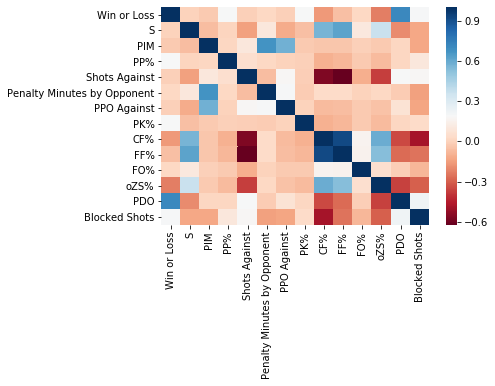

In [116]:
# to avoid multicolinearity we check the correlation between all vaiables
# calculate the correlation matrix
corr = game_data.corr()

# display the correlation matrix
display(corr)

# plot the correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

<font color='red'>**Variables close to 1 and -1 should be removed** </font>

In [117]:
#remove FF% - too much correlation with CF%
game_data = game_data.drop(['FF%'], axis = 1)

## Build the Model
The first thing we need to do is, define our exploratory variables and our explanatory variable. From here, let's split the data into a training and testing set; a healthy ratio is 20% testing and 80% training but a 30% 70% split is also ok.

After splitting the data, we will create an instance of the linear regression model and pass through the X_train and y_train variables using the fit() function.

In [118]:
# define our input variable (X) & output variable (Y)
# input contains explanatory variables and output contains goals against (GA)
X = game_data.drop('Win or Loss', axis = 1)
Y = game_data[['Win or Loss']]

# Split X and y into X_
#20% of data will be use for testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

X_test

,S,PIM,PP%,Shots Against,Penalty Minutes by Opponent,PPO Against,PK%,CF%,FO%,oZS%,PDO,Blocked Shots
ID,,,,,,,,,,,,
EDM_61,21.0,2.0,0.0,34.0,2.0,1.0,100.00,35.8,54.7,35.3,108.5,15.0
ANA_44,33.0,0.0,0.0,30.0,6.0,0.0,NaN,52.6,44.4,42.5,96.7,9.0
BUF_9,24.0,2.0,0.0,28.0,2.0,1.0,0.00,40.2,50.9,33.3,109.1,18.0
NYI_11,27.0,12.0,33.0,42.0,8.0,5.0,80.00,37.5,40.0,41.1,101.4,13.0
MTL_23,40.0,23.0,0.0,38.0,13.0,4.0,75.00,57.9,50.0,58.0,98.9,9.0
ANA_59,32.0,12.0,0.0,44.0,6.0,5.0,80.00,40.6,50.0,42.1,107.1,20.0
NYR_19,41.0,10.0,50.0,24.0,8.0,5.0,60.00,57.9,47.1,70.4,79.9,11.0
ANA_72,36.0,25.0,0.0,30.0,19.0,5.0,100.00,48.8,57.1,60.0,103.8,9.0
TBL_9,32.0,10.0,60.0,29.0,22.0,4.0,75.00,50.0,42.9,56.5,117.4,11.0


In [119]:
# create a Logistic Regression model object
model = LogisticRegression()

# pass through the X_train & y_train data set
model.fit(X_train, y_train.values.ravel())

#to predict values
#model.predict(X_test)

C:\Users\jvanzalk\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#get summary of model with p-values,coefficients,r-squared
# create a OLS model
model = sm.Logit(y_train,X_train)

# fit the data
est = model.fit()

print(est.summary())

In [ ]:
# print the p-values
est.pvalues

## Remove Insignificant Variables and Run Again

In [ ]:
#remove insignificant variables
clean_game_data = game_remove_data.drop(['Penalties','Shots'], axis = 1)
clean_game_data.head()

In [ ]:
X = clean_game_data.drop('Win', axis = 1)
Y = clean_game_data[['Win']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

model = sm.Logit(y_train,X_train)

est = model.fit()

print(est.summary())

# Interpretation
We found 3 significant relationships with Wins: Blocked Shots, FO %, Hits. All 3 relationships are very weak (coefficients less than 0.1). We have an extremely small R2 (our model predicts only 3% of variability). This makes sense. If we think about all the things that might affect the outcome of a game, the factors that we've included would have a minor impact. We can think of quite a few factors that would be better predictors: high danger chances, quality of players, etc. This model should not be used to make a prediction, but the relationships are still valid.